# 1. Single-molecule data analysis

Single-molecule data analysis for a SPARXS experiment is identical to regular single-molecule analysis using Papylio, see [User Guide](../user_guide/index.rst). However, we still show an example of a complete analysis in this document.

However, to reduce processing time, it is beneficial to perform the analysis up to and including trace extraction. Then, molecule selection and trace classification can be performed after the single-molecule data is combined with the sequencing data, thereby only using the traces with a linked sequence.

Also, due to the large amount of data, it is beneficial to perform parallel processing. Therefore, at the end of the document we combine all analysis steps into a single function and run it in parallel for all different files.


The example dataset consists of the first two tiles of a SPARXS experiment on a MiSeq v3 flow cell 
(normally consisting of 19 tiles). For the experiment a four-way DNA Holliday junction was immobilized
on the flow cell surface. The DNA was labelled with two dyes: a Cy3 and Cy5 fluorophore on two of the arms. 
The flow cell was scanned with our fluorescence microscope, which has a field of view (FOV) of 32 x 64 μm, 
where we took steps of 30 and 62 μm. At each position a movie of 400 frames was taken using the green, 
561-nm laser, exciting Cy3. Additionally, before and after these a 5-frame movie was taken with the red, 
642-nm laser to verify the presence of Cy5.

In [1]:
from pathlib2 import Path
import papylio as pp
import matplotlib.pyplot as plt
import contextlib
import io

%matplotlib inline

## Experiment import

In [2]:
experiment_path = Path(r'C:\Users\user\Desktop\SPARXS example dataset')

In [3]:
exp = pp.Experiment(experiment_path)

Import files: 100%|██████████████████████████████████████████████████████████████| 4190/4190 [00:00<00:00, 6450.70it/s]



File(Single-molecule data - bead slide\Bead slide TIRF 561 001) used as mapping

Initialize experiment: 
C:\Users\user\Desktop\SPARXS example dataset



Set rotation parameter.
The software assumes two vertical channels (left Cy3 and right Cy5), however, the images have two horizontal channels. Therefore, the data obtained from the movie needs to be rotated counterclockwise 1 x 90 degrees, i.e. rot90 = 1. (Definition is the same as for numpy.rot90.)

In [4]:
exp.configuration['movie']['rot90'] = 1
exp.configuration.save()
exp.files.movie.rot90 = 1

All files are stored in the files attribute of the experiment. Showing the first 10 files:

In [5]:
exp.files[0:10]

FileCollection([File(Cluster data for global alignment\TIRF 642 0001),
                File(Cluster data for global alignment\TIRF 642 0002),
                File(Cluster data for global alignment\TIRF 642 0003),
                File(Cluster data for global alignment\TIRF 642 0004),
                File(Cluster data for global alignment\TIRF 642 0005),
                File(Cluster data for global alignment\TIRF 642 0006),
                File(Cluster data for global alignment\TIRF 642 0007),
                File(Cluster data for global alignment\TIRF 642 0008),
                File(Cluster data for global alignment\TIRF 642 0009),
                File(Cluster data for global alignment\TIRF 642 0010)])

Note: to import your own image files with correct metadata, you may need to adjust some of the python files in the movie folder of the traceAnalysis package. For tif files you need to adjust the `tif.py` file, where in the `_read_header` method an `elif` statement can be added for other metadata. For `.pma`, `.sifx` and `.nd2` files, processing files are already present. For other file types you can add additional python files, using the `tif.py` file as an example.

To allow handling the files images with the green laser and those with the red laser, before and after the main movie, we store them in separate variables. Additionally, we find the file that will be used for aligning the Cy3- and Cy5-emission channels.

To do this we use the select method, for which the first argument is the string that needs to be contained in the attribute given as the second argument.

In [6]:
files_bead_slide = exp.files.select('Bead slide', 'name')
files_darkfield_correction = exp.files.select('Single-molecule data - darkfield correction', 'relativePath')
files_green_laser = exp.files.select('Single-molecule data - green laser', 'relativePath')
files_red_laser_before = exp.files.select('Single-molecule data - red laser before', 'relativePath')
files_red_laser_after = exp.files.select('Single-molecule data - red laser after', 'relativePath')

Tell the software which files are obtained with the red laser (i.e. illuminations 0 and 1 correspond to green and red, respectively).

In [7]:
files_red_laser_before.movie.illumination_arrangement = [1]
files_red_laser_after.movie.illumination_arrangement = [1]

To make the red laser files accessable from the green laser files, add them as an attribute.

In [8]:
for file_green, file_red_before, file_red_after in zip(files_green_laser, files_red_laser_before,
                                                       files_red_laser_after):
    if (file_green.name[-4:] == file_red_before.name[-4:] == file_red_after.name[-4:]):
        file_green.file_red_before = file_red_before
        file_green.file_red_after = file_red_after
    else:
        raise ValueError('File names not equal for green, red before and red after.')

In [9]:
files_green_laser[0:10].print()

  0.  Single-molecule data - green laser - 001-100\TIRF 561 0001
  1.  Single-molecule data - green laser - 001-100\TIRF 561 0002
  2.  Single-molecule data - green laser - 001-100\TIRF 561 0003
  3.  Single-molecule data - green laser - 001-100\TIRF 561 0004
  4.  Single-molecule data - green laser - 001-100\TIRF 561 0005
  5.  Single-molecule data - green laser - 001-100\TIRF 561 0006
  6.  Single-molecule data - green laser - 001-100\TIRF 561 0007
  7.  Single-molecule data - green laser - 001-100\TIRF 561 0008
  8.  Single-molecule data - green laser - 001-100\TIRF 561 0009
  9.  Single-molecule data - green laser - 001-100\TIRF 561 0010


## Channel alignment

To know which location in the donor channel corresponds to which location in the acceptor channel, we have to perform channel alignment. We used an image of a bead slide containing beads that emit signal in both emission channels. The `File.perform_mapping` method finds the location of the beads in both channels using an average image of the first 20 frames (this image is stored in a `_ave_f0-20_i0.tif` file. Then it finds the transformation between the coordinates of the two channels. The result is stored in a `.mapping` file.

polynomial
Donor: 548, Acceptor: 496
Iteration: 0 	 Mean squared error: 1.7164376583877852 	 Number of pairs: 404
Iteration: 1 	 Mean squared error: 0.18838727921075776 	 Number of pairs: 439
Iteration: 2 	 Mean squared error: 0.1855005539225138 	 Number of pairs: 439
Iteration: 3 	 Mean squared error: 0.1855005539225138 	 Number of pairs: 439
Final 		 Mean squared error: 0.18059069048966106 	 Number of pairs: 439
Iterative closest point match
Mean-squared error: 0.18059069048966106
Number of iterations: 3

File(Single-molecule data - bead slide\Bead slide TIRF 561 001) used as mapping


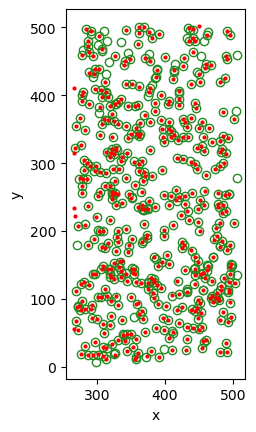

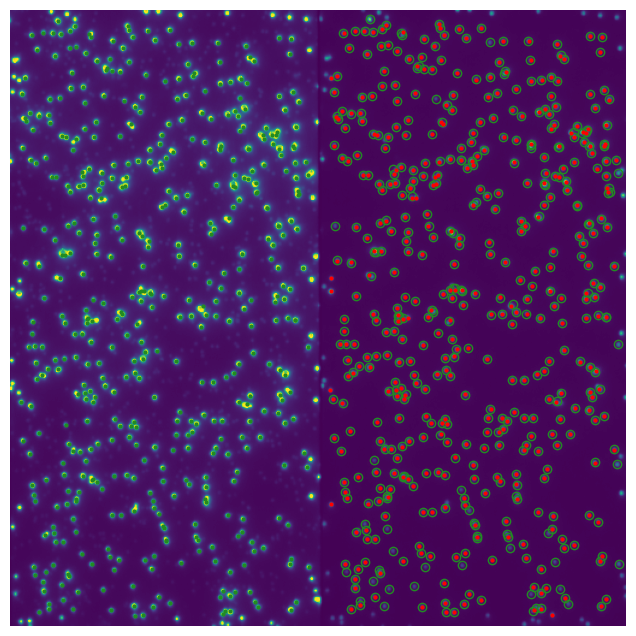

In [10]:
file_channel_mapping = files_bead_slide[0]
file_channel_mapping.perform_mapping(method='icp',                               # The iterative closest point (icp) algorithm generally works well. 
                                     distance_threshold=3,                       # Distance threshold for the icp algorithm.
                                     transformation_type='polynomial',           
                                     initial_translation='width/2',
                                     peak_finding=dict(
                                         donor=dict(
                                             method='local-maximum-auto',
                                             fraction_difference=0.5,            # Number between 0 and 1 to tweak how many molecules are found 
                                             filter_neighbourhood_size_min=10,
                                             filter_neighbourhood_size_max=5),
                                         acceptor=dict(
                                             method='local-maximum-auto',        
                                             fraction_difference=0.5,            # Number between 0 and 1 to tweak how many molecules are found 
                                             filter_neighbourhood_size_min=10,
                                             filter_neighbourhood_size_max=5)
                                     ),
                                     coordinate_optimization=dict(
                                         coordinates_after_gaussian_fit=dict(
                                            gaussian_width=5),                   # Number of pixels to be fit with a gaussian to improve localization
                                         coordinates_within_margin=dict(
                                            margin=8)                            # Margin (number of pixels) from the edge to remove the points from.
                                        )
                                     )

## Spatial shading correction (optional)

To estimate the flatfield (and possibly darkfield) correction using e.g. the [BaSiC algorithm](https://www.nature.com/articles/ncomms14836).
The darkfield image was acquired directly on the microscope. First we specify which file we want to use for the darkfield correction. An average image with the filname `darkfield.tif` is placed in the main folder. If this file is present when loading the experiment, it will be used automatically as a correction and as a first step before determining the flatfield correction. Running the following lines will produce two files for the flatfield correction in the main directory: `flatfield_i0.tif` and `flatfield_i1.tif`.

In [11]:
files_darkfield_correction[0].use_for_darkfield_correction()

In [12]:
# For green illumination
exp.determine_flatfield_and_darkfield_corrections(files_green_laser[::10], method='BaSiC', illumination_index=0, frame_index=2,
                                                  estimate_darkfield=False, l_s=5, l_d=5)
# For red illumination
exp.determine_flatfield_and_darkfield_corrections(files_red_laser_before[::10], method='BaSiC', illumination_index=1,
                                                  frame_index=2, estimate_darkfield=False, l_s=5, l_d=5)

# Uses the second frame of each file to determine the flatfield correction. l_s and l_d are parameters for the 'BaSiC' algorithm.

Reweighting Iteration:  30%|██████████████████                                          | 3/10 [00:08<00:19,  2.72s/it]


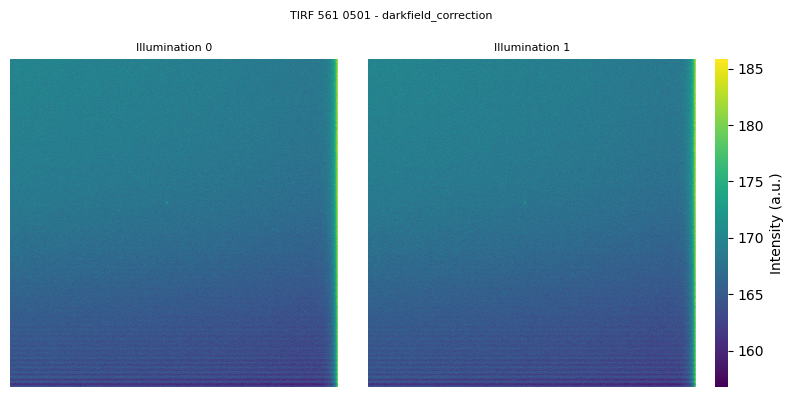

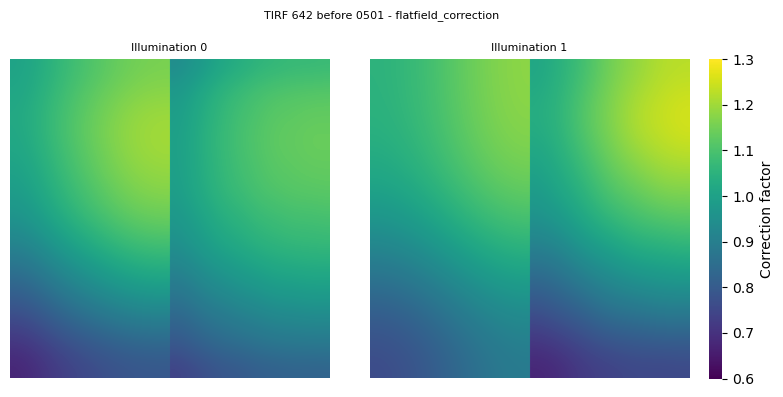

In [13]:
files_green_laser[500].movie.show_correction('darkfield_correction', save=True)
files_red_laser_before[500].movie.show_correction('flatfield_correction', save=True, vmin=0.6, vmax=1.3)

## Background subtraction
To obtain correct FRET values it is important to perform background correction. There are three types of background subtraction that can be performed. A temporal background subtraction that corrects variations in background over time (but not in x and y); a spatial background correction that corrects variations over the x and y (but not over time); and a general background correction, which is a single value for the entire movie.
The background corrections are stored in an `_corrections.nc` file for each movie.

In [14]:
# Select an example image
file_green = files_green_laser[500]

Average image: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


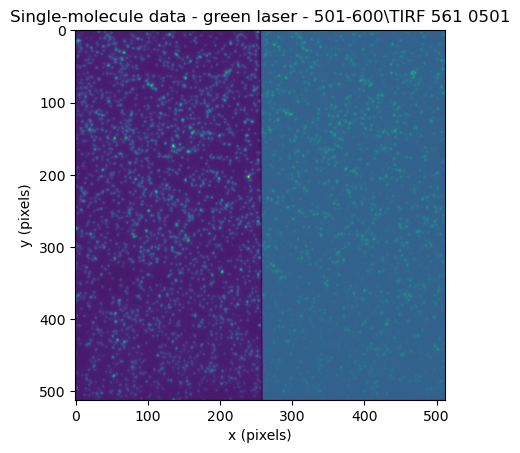

In [15]:
file_green.movie.reset_corrections() # Reset all corrections (except darkfield and flatfield corrections)
file_green.get_projection_image(load=False) # Remake projection image
file_green.show_average_image()

### Temporal background and illumination correction
If there are fluorophores in solutions, the background may change slightly over time due to e.g. bleaching.
In our case there were no fluorophores in solution, but our laser showed slight intensity fluctuations.
We estimated this from the variations in the autofluorescent background of the acceptor channel and corrected for it. 

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 1019.44it/s]


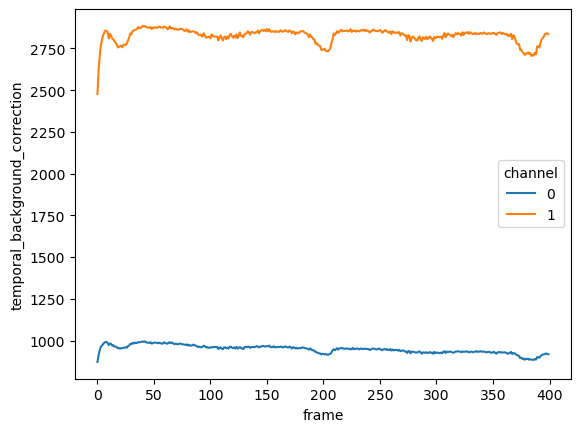

In [16]:
file_green.movie.determine_temporal_background_correction(method='median')

plt.figure()
file_green.movie.corrections.temporal_background_correction.plot.line(x='frame')

In [17]:
temporal_illumination_correction = file_green.movie.corrections.temporal_background_correction.sel(channel=1) / 2750
temporal_background_correction = file_green.movie.corrections.temporal_background_correction / temporal_illumination_correction

file_green.movie.save_corrections(temporal_background_correction=temporal_background_correction,
                                  temporal_illumination_correction=temporal_illumination_correction)

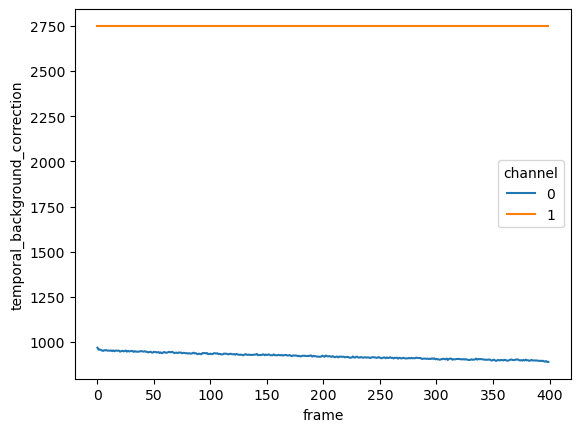

In [18]:
plt.figure()
file_green.movie.corrections.temporal_background_correction.plot.line(x='frame')

### Spatial background correction
To compensate for variations in background over the image, the background is estimated using a median filter.

In [19]:
file_green.movie.determine_spatial_background_correction(method='median_filter', size=20)

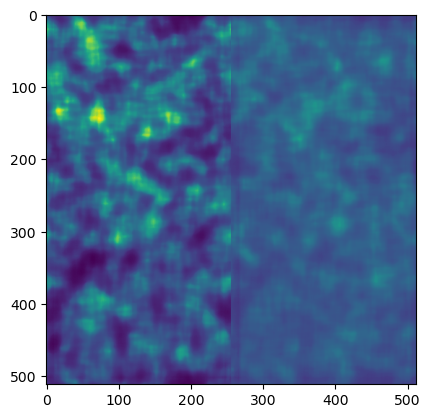

In [20]:
plt.figure()
plt.imshow(file_green.movie.corrections.spatial_background_correction.sel(illumination=0).stack(x2=('channel','x')).values)

### General background correction
Because the median filter overestimates the signal, we apply a more accurate general background correction (a single value per channel), by fitting the background peak in the intensity histogram. file_green.movie.determine_general_background_correction('fit_background_peak')

In [21]:
file_green.movie.determine_general_background_correction(method='fit_background_peak')

In [22]:
print(file_green.movie.corrections.general_background_correction)

<xarray.DataArray 'general_background_correction' (illumination: 2, channel: 2)>
array([[-50, -18],
       [  0,   0]])
Coordinates:
  * channel       (channel) int32 0 1
  * illumination  (illumination) int32 0 1


### Background correction result

Average image: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Single-molecule data - green laser - 501-600\\TIRF 561 0501'}, xlabel='x (pixels)', ylabel='y (pixels)'>)

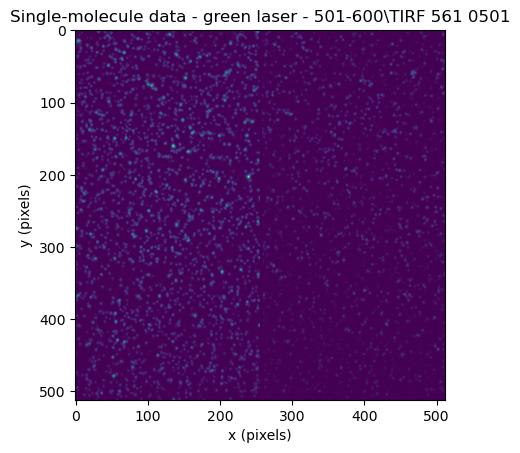

In [23]:
file_green.get_projection_image(load=False) # Remake projection image
file_green.show_image(vmin=0)

## Find coordinates
Here the locations of the single-molecules are identified.

Average image: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.43it/s]


 Finding molecules in File(Single-molecule data - green laser - 501-600\TIRF 561 0501)
   1715 molecules found


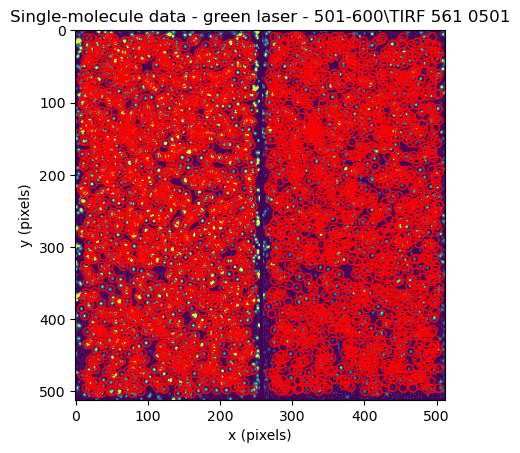

In [24]:
file_green.get_projection_image(load=False) # Remake projection image

file_green.find_coordinates(channels=['donor', 'acceptor'], 
                            method='sum_channels',                               # If only one channel, use 'by_channel'; If two channels, use 'sum_channels' or 'average_channels'.
                            projection_image=dict(projection_type='average',     # Choose average or maximum
                                                  frame_range=(0, 20),           # The range of frames to use, syntax similar to the range function, so [0, 20] represents the first 20 frames.
                                                  illumination=0),               # 0 corresponds to green illumination
                            peak_finding=dict(method='local-maximum-auto',
                                              fraction_difference=0.35,          # Number between 0 and 1 to tweak how many molecules are found
                                              filter_neighbourhood_size_min=10,
                                              filter_neighbourhood_size_max=3),
                            coordinate_optimization=dict(coordinates_within_margin=dict(
                                                            margin=8),           # Number of pixels to be fit with a gaussian to improve localization
                                                         coordinates_after_gaussian_fit=dict(
                                                            gaussian_width=3))   # Margin (number of pixels) from the edge to remove the points from.
                            )

fig, ax = plt.subplots()#figsize=(10,8))
file_green.show_coordinates_in_image(vmin=0, vmax=1000, figure=fig)

The `File.find_coordinates` method creates a [netCDF](https://www.unidata.ucar.edu/software/netcdf/) (`.nc`) file for each movie. The `.nc` file contains the pixel coordinates of molecules and is used to store all single-molecule data that will produced for this file, i.e. fluorescence intensity, FRET, selections, classifications and associated sequences. To look view the dataset of a file, one can run:

In [25]:
file_green.dataset

<xarray.Dataset>
Dimensions:           (molecule: 1715, channel: 2, dimension: 2)
Coordinates:
    molecule_in_file  (molecule) int32 0 1 2 3 4 5 ... 1710 1711 1712 1713 1714
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
  * channel           (channel) int64 0 1
  * dimension         (dimension) |S1 b'x' b'y'
Dimensions without coordinates: molecule
Data variables:
    selected          (molecule) bool False False False ... False False False
    coordinates       (molecule, channel, dimension) float64 243.9 ... 77.39

This line loads the dataset using the [xarray](https://docs.xarray.dev/en/stable/index.html) python package, which is a package for working with multidimensional data. The dataset is a container for multiple dataarrays. In this case there is a `selected` dataarray, which is a boolean array indicating whether or not a molecule is selected (this will be used later). Additionally, there is the `coordinates` dataarray wich holds the x and y coordinates for each molecule in each channel. The dataarrays or even full datasets can be easily sliced, manupulated, saved and loaded. Note that `.nc` files can be opened in many other programming languages as well. For all functions see the [xarray documentation](https://docs.xarray.dev/en/stable/index.html).

In multiple of the following steps, the dataset will be extended with several dataarrays.

## Determine PSF size (optional)

In case the size of the point spread function (PSF) is not known, the following method can be run which estimates the standard deviation of the PSF from the spots in the image.

C:\Users\user\miniconda3\envs\trace_analysis\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1.009993987817876

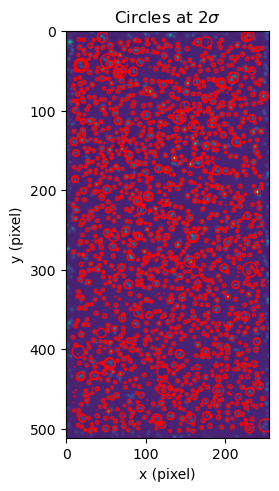

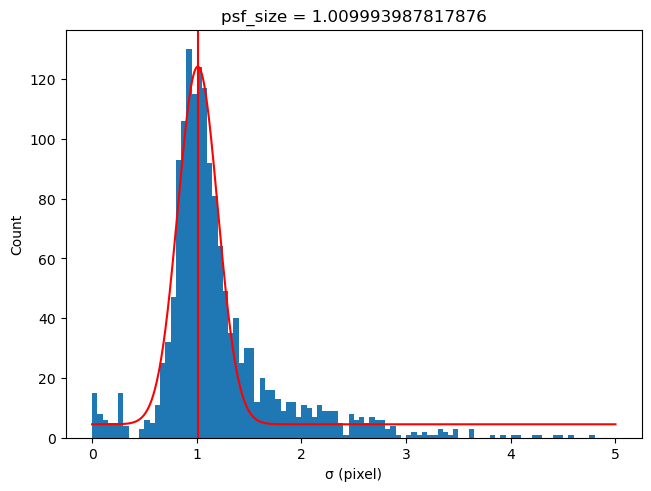

In [26]:
file_green.determine_psf_size()

## Extract traces
Using additional, but optional alpha, gamma and background corrections, the single-molecule time traces can be extracted.
The mask size should be set to the standard deviation of the point spread function measured for our microscope.

In [27]:
file_green.extract_traces(mask_size=1.01, background_correction=(-300, -100), alpha_correction=0.05, gamma_correction=1.5)

  Extracting traces in File(Single-molecule data - green laser - 501-600\TIRF 561 0501)


TIRF 561 0501: 100%|████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 256.88it/s]


Now the dataset in the `.nc` file is expanded with the `intensity`, `intensity_raw` and `FRET` data variables:

In [28]:
file_green.dataset

<xarray.Dataset>
Dimensions:           (molecule: 1715, channel: 2, dimension: 2, frame: 400)
Coordinates:
    molecule_in_file  (molecule) int32 0 1 2 3 4 5 ... 1710 1711 1712 1713 1714
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
  * channel           (channel) int64 0 1
  * dimension         (dimension) |S1 b'x' b'y'
    time              (frame) float64 0.0 0.121 0.244 ... 48.62 48.75 48.87
  * frame             (frame) int32 0 1 2 3 4 5 6 ... 394 395 396 397 398 399
    illumination      (frame) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: molecule
Data variables:
    selected          (molecule) bool False False False ... False False False
    coordinates       (molecule, channel, dimension) float64 243.9 ... 77.39
    intensity         (molecule, channel, frame) float64 2.898e+04 ... -2.066...
    intensity_raw     (molecule, channel, frame) float64 1.81e+04 ... -2.217e+03
    FRET              (molecule, frame) float64 0.2133 0.1391 ... 0.1464 0.6694

In [29]:
file_green.dataset.intensity # Or you could also use file_green.intensity directly.

<xarray.DataArray 'intensity' (molecule: 1715, channel: 2, frame: 400)>
array([[[28975.97227059, 31580.00782344, 32614.46511028, ...,
         27713.09534019, 18902.4053957 , 18615.01418201],
        [ 7856.32431185,  5104.66630725, 10642.30933833, ...,
          5002.83909417, 10344.1440267 , 10556.69203597]],

       [[15493.28816622, 13474.11362244,  8778.92220836, ...,
         10595.31994378, 11164.34204   , 10596.84833099],
        [12312.35617901, 12985.51965608, 13285.85387414, ...,
          9638.89491729, 10376.03105074, 12897.55429275]],

       [[ 8831.64117126,  4886.00151843,  5391.84868229, ...,
         11972.75317319, 13077.07842652, 16182.08074911],
        [ 7804.6098217 , 13823.44885838, 12263.87785515, ...,
         -3086.90507183, -1187.01787197,  -188.81077161]],

       ...,

       [[20777.30955943, 16343.40229168, 17795.81041354, ...,
         18273.36211846, 16340.95374724, 15943.8535936 ],
        [ 1319.23573918,  1920.10596601,  -344.4333578 , ...,
         -2897.44659654,   579.79353219,   891.13655644]],

       [[24065.44155189, 24211.63512206, 26465.09742933, ...,
         10191.50409444, 11988.24787106, 10176.55391391],
        [ 2363.22145245,  2370.83790745,  2599.66260594, ...,
          3022.1389737 ,   405.0688531 ,  1122.5420595 ]],

       [[20866.42959906, 16662.70214387, 18479.9853852 , ...,
         -1981.20665671, -3071.92275343, -1020.31834956],
        [ -212.07637597,  -883.91587396, -1803.26307486, ...,
          1895.98240637,  -526.70276168, -2066.20654648]]])
Coordinates:
    molecule_in_file  (molecule) int32 0 1 2 3 4 5 ... 1710 1711 1712 1713 1714
    file              (molecule) |S58 b'Single-molecule data - green laser - ...
  * channel           (channel) int64 0 1
    time              (frame) float64 0.0 0.121 0.244 ... 48.62 48.75 48.87
  * frame             (frame) int32 0 1 2 3 4 5 6 ... 394 395 396 397 398 399
    illumination      (frame) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: molecule
Attributes:
    background_correction:  [-300 -100]
    gamma_correction:       1.5
    alpha_correction:       0.05

## Evaluate traces

In [30]:
file_green.show_traces(plot_variables=['intensity', 'FRET'], 
                       ylims=[(0, 35000), (0, 1)], 
                       colours=[('g', 'r'), ('b')],
                       selected=False, 
                       split_illuminations=True)
%matplotlib inline

Text(0, 0.5, 'FRET')

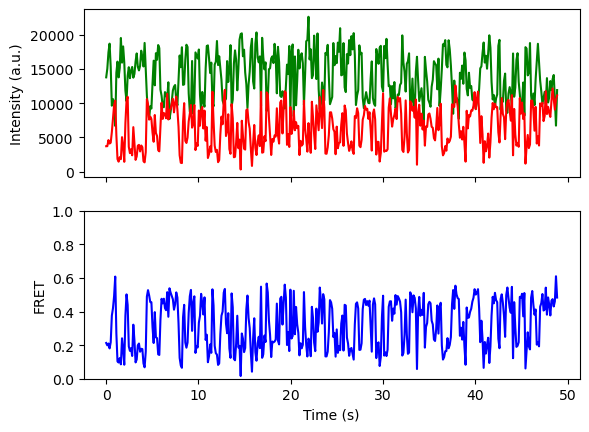

In [31]:
ds = file_green.dataset.sel(molecule=980)
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(ds.time, ds.intensity.sel(channel=0), c='g')
axs[0].plot(ds.time, ds.intensity.sel(channel=1), c='r')
axs[1].plot(ds.time, ds.FRET, c='b')
axs[1].set_ylim(0,1)
axs[1].set_xlabel('Time (s)')
axs[0].set_ylabel('Intensity (a.u.)')
axs[1].set_ylabel('FRET')

## Full pipeline

Each of the previous steps can be separately applied to each file. However, when processing multiple files and when using parallel processing it will be beneficial to combine all the analysis steps to use the resources more optimally.

In addition some steps were added to process the red laser files.

In [32]:
def single_molecule_pipeline(file_green):
    try:
        with contextlib.redirect_stdout(io.StringIO()):
            with contextlib.redirect_stderr(io.StringIO()):
                file_red_before = file_green.file_red_before
                file_red_after = file_green.file_red_after

                file_green.movie.determine_temporal_background_correction('median')

                temporal_illumination_correction = file_green.movie.corrections.temporal_background_correction.sel(channel=1) / 2750
                temporal_background_correction = file_green.movie.corrections.temporal_background_correction / temporal_illumination_correction

                file_green.movie.save_corrections(temporal_background_correction=temporal_background_correction,
                                                  temporal_illumination_correction=temporal_illumination_correction)

                file_green.movie.determine_spatial_background_correction(method='median_filter', size=20)

                file_green.movie.determine_general_background_correction('fit_background_peak')

                file_red_before.movie.determine_spatial_background_correction(method='median_filter', size=20)
                file_red_after.movie.determine_spatial_background_correction(method='median_filter', size=20)

                file_red_before.movie.determine_general_background_correction('fit_background_peak')
                file_red_after.movie.determine_general_background_correction('fit_background_peak')

                file_green.get_projection_image(load=False)

                file_green.find_coordinates(channels=['donor', 'acceptor'], method='sum_channels',
                                            projection_image=dict(projection_type='average', frame_range=(0, 20),
                                                                  illumination=0),
                                            sliding_window=dict(use_sliding_window=False, frame_increment=20,
                                                                minimal_point_separation=2),
                                            peak_finding=dict(method='local-maximum-auto',
                                                              fraction_difference=0.35,
                                                              filter_neighbourhood_size_min=10,
                                                              filter_neighbourhood_size_max=3),
                                            coordinate_optimization=dict(coordinates_within_margin=dict(margin=8),
                                                                         coordinates_after_gaussian_fit=dict(
                                                                             gaussian_width=3))
                                            )

                file_red_before.coordinates = file_green.coordinates
                file_red_after.coordinates = file_green.coordinates

                file_green.extract_traces(mask_size='BN-TIRF', background_correction=(-300, -100), alpha_correction=0.05,
                                                   gamma_correction=1.5)
                file_red_before.extract_traces(mask_size='BN-TIRF')
                file_red_after.extract_traces(mask_size='BN-TIRF')

                intensity_red_before = file_red_before.intensity.mean('frame')
                intensity_red_before = intensity_red_before.drop('file')
                intensity_red_before.name = 'intensity_red_before'
                intensity_red_before.to_netcdf(file_green.absoluteFilePath.with_suffix('.nc'), engine='h5netcdf', mode='a')

                intensity_red_after = file_red_after.intensity.mean('frame')
                intensity_red_after = intensity_red_after.drop('file')
                intensity_red_after.name = 'intensity_red_after'
                intensity_red_after.to_netcdf(file_green.absoluteFilePath.with_suffix('.nc'), engine='h5netcdf', mode='a')

    except:
        print('Error', file_green)

In [33]:
# Test the full pipeline on one of the files
single_molecule_pipeline(files_green_laser[500])

In [34]:
files_green_laser.number_of_cores = 20

In [35]:
# Perform on all files
files_green_laser.parallel.map(single_molecule_pipeline)()

  0%|                                                                                          | 0/896 [00:00<?, ?it/s]

Parallel processing


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [21:31<00:00,  1.44s/it]
